In [812]:

from rdkit import Chem
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem import BRICS

import re
import pandas as pd
from rdkit.Chem import rdmolops
import datamol as dm

In [813]:
smiles_list = pd.read_csv('../dataset/zinc_250k.csv')['smiles'].tolist()

In [814]:
# Replace the dummy atom index
pattern = r'\[\d+\*\]'

In [815]:
def brics(smiles):
    dm.disable_rdkit_log()
    
    mol = Chem.MolFromSmiles(smiles)
    
    mol = dm.standardize_mol(
        mol,
        disconnect_metals=False,
        normalize=True,
        reionize=True,
        uncharge=True,
        stereo=True,
    )
    
    fragmented_mol = rdmolops.FragmentOnBRICSBonds(mol)
    fragments = Chem.GetMolFrags(fragmented_mol, asMols=True, sanitizeFrags=True)
    
    # Kekulize the fragments
    for fragment in fragments:
        Chem.Kekulize(fragment, clearAromaticFlags=True) 
    
    # Break the ring connecting bonds
    new_fragments = []
    for frag in fragments:
        new_fragments.extend(break_ring_connecting_bonds(frag))
    
    # Remove fragment where dummy atom is connected via a NON-single bond
    new_fragments = [frag for frag in new_fragments if not has_attachment_point_via_non_single_bond(frag)]
    
    fragment_smiles = [Chem.MolToSmiles(fragment, isomericSmiles=False) for fragment in new_fragments]
    fragment_smiles = [re.sub(pattern, '[*]', smiles) for smiles in fragment_smiles]
    
    return set(fragment_smiles)

In [816]:
def has_attachment_point_via_non_single_bond(frag):
    for bond in frag.GetBonds():
        atom1, atom2 = bond.GetBeginAtom(), bond.GetEndAtom()
        if atom1.GetAtomicNum() == 0 or atom2.GetAtomicNum() == 0:
            if bond.GetBondTypeAsDouble() != 1.0:
                return True
    return False

In [817]:
def break_ring_connecting_bonds(frag_mol):
    ring_info = frag_mol.GetRingInfo()
    ring_atoms = set(sum(ring_info.AtomRings(), ()))
    ring_bonds = set(sum(ring_info.BondRings(), ()))

    ring_connecting_bonds = []

    for bond in frag_mol.GetBonds():
        if bond.GetIdx() not in ring_bonds:
            atom1, atom2 = bond.GetBeginAtom(), bond.GetEndAtom()
            if atom1.GetAtomicNum() == 0 or atom2.GetAtomicNum() == 0:
                # Skip this bond if either atom is a dummy atom
                continue
            
            # Skip this bond if it is not a single bond
            if bond.GetBondTypeAsDouble() != 1.0:
                continue
            
            atom1_idx, atom2_idx = atom1.GetIdx(), atom2.GetIdx()
            if atom1_idx in ring_atoms or atom2_idx in ring_atoms:
                ring_connecting_bonds.append(bond.GetIdx())
    
    if len(ring_connecting_bonds) == 0:
        return [frag_mol]
    
    fragmented_mol = Chem.FragmentOnBonds(
        frag_mol, ring_connecting_bonds)
    return Chem.GetMolFrags(fragmented_mol, asMols=True, sanitizeFrags=True)        

In [818]:
# brics_frags = [Chem.MolFromSmiles(smi) for smi in brics(smiles_list[3])]
# brics_frags = list(brics_frags)
# MolsToGridImage(brics_frags)

In [819]:
from tqdm import tqdm
from collections import defaultdict

counter = defaultdict(int)

Create all fragments

In [820]:
for smi in tqdm(smiles_list):
    frags = brics(smi)
    for frag in frags:
        counter[frag] += 1

100%|██████████| 249455/249455 [10:18<00:00, 403.39it/s]


First, merge all fragments that are same (differ by connection point) - Second, compute all connection points 

In [821]:
def get_stems(frag_smi):
    mol = Chem.MolFromSmiles(frag_smi)
    Chem.Kekulize(mol, clearAromaticFlags=True)

    original_stem_indices = []    

    # Get the mapping from the original index to the index after removing dummy atoms
    j = 0
    no_dummy_idx_map = {}
    for i, atom in enumerate(mol.GetAtoms()):
        if atom.GetAtomicNum() != 0:
            no_dummy_idx_map[i] = j
            j += 1

    # Get the indices of the atoms that are connected to the dummy atoms
    for bond in mol.GetBonds():
        atom1, atom2 = bond.GetBeginAtom(), bond.GetEndAtom()
        if atom1.GetAtomicNum() == 0:
            original_stem_indices.append(no_dummy_idx_map[atom2.GetIdx()])
        if atom2.GetAtomicNum() == 0:
            original_stem_indices.append(no_dummy_idx_map[atom1.GetIdx()])
    
    no_wildcard_mol = Chem.DeleteSubstructs(mol, Chem.MolFromSmiles('[*]'))
    _ = Chem.MolFromSmiles(Chem.MolToSmiles(no_wildcard_mol))
    
    # Compute the new ordering when we cannocalize the smiles
    new_order = list(map(int, no_wildcard_mol.GetProp("_smilesAtomOutputOrder")[1:-2].split(",")))
    
    stems = []
    for idx in original_stem_indices:
        stems.append(new_order.index(idx))
    
    return stems

In [830]:
non_dup_counter = defaultdict(int)
mapping = defaultdict(set)

for frag_smi, count in tqdm(counter.items()):
    if count > 50:
        start_mol = Chem.MolFromSmiles(frag_smi)
        Chem.Kekulize(start_mol, clearAromaticFlags=True)        
        no_wildcard_mol = Chem.DeleteSubstructs(start_mol, Chem.MolFromSmiles('[*]'))
        no_wildcard_smiles = Chem.MolToSmiles(no_wildcard_mol)
        non_dup_counter[no_wildcard_smiles] += count
        mapping[no_wildcard_smiles].add(frag_smi)

100%|██████████| 15808/15808 [00:00<00:00, 119567.56it/s]


In [831]:
key_to_stems = defaultdict(set)

for key, frag_set in tqdm(mapping.items()):
    for frag_smi in frag_set:
        for stem in get_stems(frag_smi):
            key_to_stems[key].add(stem)

100%|██████████| 475/475 [00:00<00:00, 1320.25it/s]


In [832]:
# key = 'C1=CSC=N1'
# print(key_to_stems[key])
# MolsToGridImage([Chem.MolFromSmiles(smi) for smi in mapping[key]], legends=[f'{str(counter[smi])} {[" ".join([str(i) for i in get_stems(smi)])]}' for smi in mapping[key]])

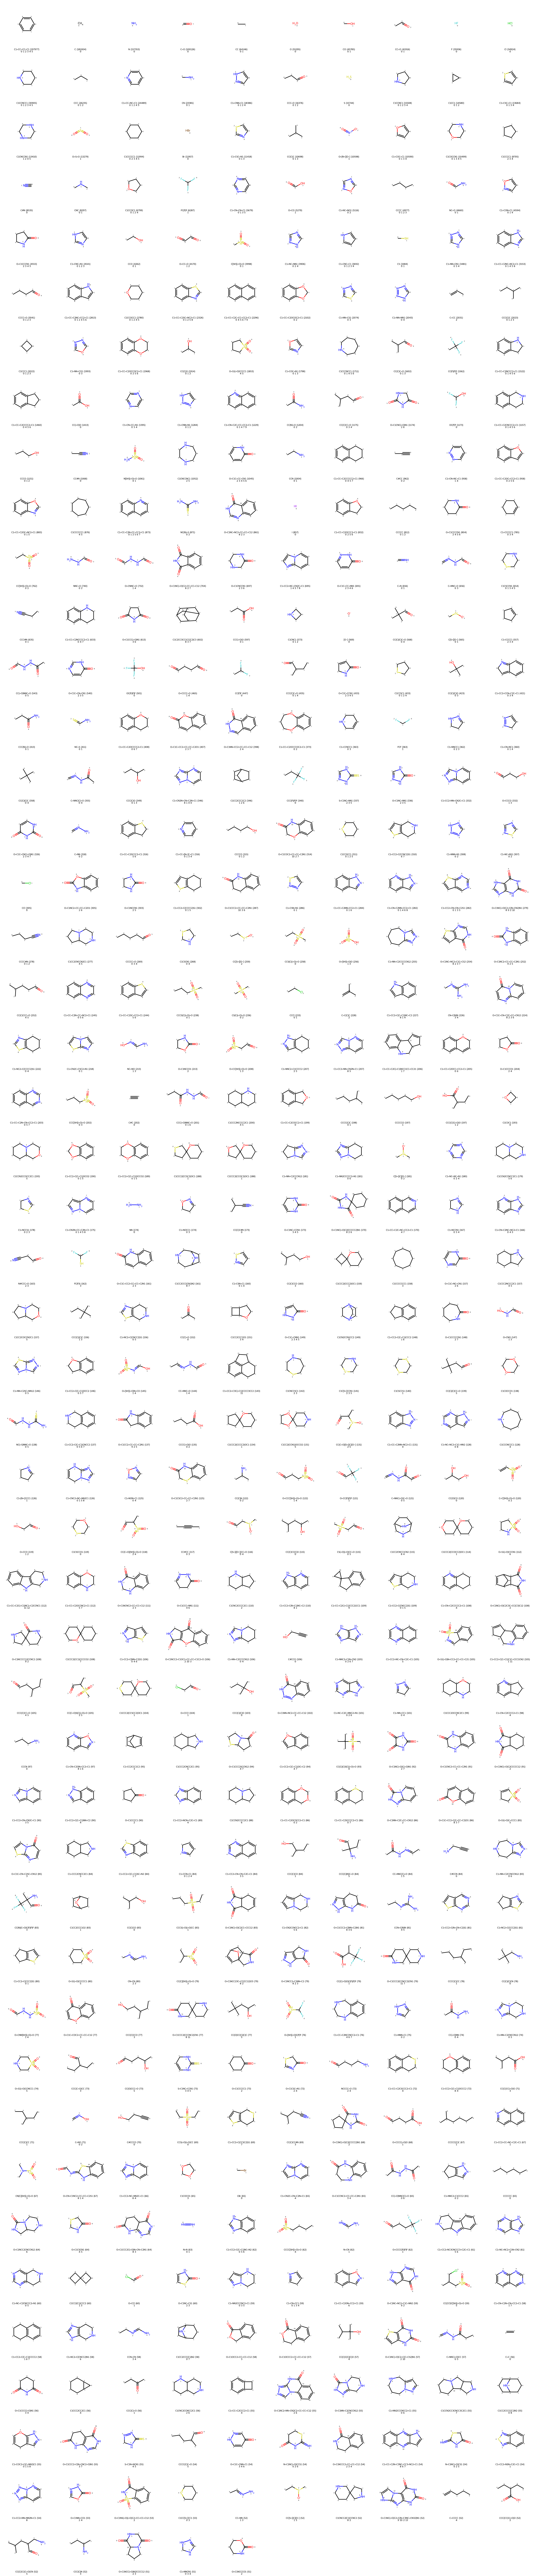

In [837]:
sorted_counter = dict(sorted(non_dup_counter.items(), key=lambda x: x[1], reverse=True))

size = 475

mols = [Chem.MolFromSmiles(smi) for smi in sorted_counter.keys()]

# For visualization reasons only
# for mol in mols:
#     if mol is not None:
#         for i, atom in enumerate(mol.GetAtoms()):
#             atom.SetAtomMapNum(i)

MolsToGridImage(mols[:size], molsPerRow=10, subImgSize=(200, 200), legends=[f'{smi} ({freq}) \n{" ".join([str(i) for i in key_to_stems[smi]])}' for smi, freq in sorted_counter.items()][:size], maxMols=size)

In [841]:
vocab = []
for smi, _ in sorted_counter.items():
    vocab.append(
        [smi, list(key_to_stems[smi])]
    )

In [843]:
import torch

torch.save(vocab, '../src/tacogfn/const/vocab_store/zinc250k_50cutoff_bric_vocabs.pt')

/home/tsa87/anaconda3/envs/tacogfn/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [844]:
vocab

[['C1=CC=CC=C1', [0, 1, 2, 3, 4, 5]],
 ['C', [0]],
 ['N', [0]],
 ['C=O', [0]],
 ['CC', [0, 1]],
 ['O', [0]],
 ['CO', [0, 1]],
 ['CC=O', [0, 1]],
 ['F', [0]],
 ['Cl', [0]],
 ['C1CCNCC1', [0, 1, 2, 3, 4, 5]],
 ['CCC', [0, 1, 2]],
 ['C1=CC=NC=C1', [0, 1, 2, 4, 5]],
 ['CN', [0, 1]],
 ['C1=CNN=C1', [0, 1, 2, 4]],
 ['CCC=O', [0, 1, 2]],
 ['S', [0]],
 ['C1CCNC1', [0, 1, 2, 3, 4]],
 ['C1CC1', [0, 1, 2]],
 ['C1=CSC=C1', [0, 1, 3, 4]],
 ['C1CNCCN1', [1, 2, 4, 5]],
 ['O=S=O', [1]],
 ['C1CCCCC1', [0, 2, 3, 4, 5]],
 ['Br', [0]],
 ['C1=CSC=N1', [0, 1, 3]],
 ['CC(C)C', [0, 1, 3]],
 ['O=[N+][O-]', [1]],
 ['C1=COC=C1', [0, 1, 3, 4]],
 ['C1COCCN1', [0, 1, 3, 4, 5]],
 ['C1CCCC1', [2, 3, 4]],
 ['C#N', [0]],
 ['CNC', [0, 1]],
 ['C1CCOC1', [0, 1, 2, 4]],
 ['FC(F)F', [1]],
 ['C1=CN=CN=C1', [0, 1, 3, 5]],
 ['O=CO', [1]],
 ['C1=NC=NO1', [0, 2]],
 ['CCCC', [0, 1, 2, 3]],
 ['NC=O', [0, 1]],
 ['C1=CON=C1', [0, 1, 4]],
 ['O=C1CCCN1', [2, 3, 4, 5]],
 ['C1=CNC=N1', [0, 1, 2, 3]],
 ['CCO', [0, 1]],
 ['O=CC=O', [1, 2]